<a href="https://colab.research.google.com/github/minassy/ISID_2021/blob/main/210924_AutedFE%E6%A4%9C%E8%A8%8E_DictL_%E4%BB%96%E7%89%B9%E5%BE%B4_%E3%83%A6%E3%83%8B%E3%83%83%E3%83%881.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [2]:
#作業基本ディレクトリ
DIR = 'drive/MyDrive/00_Competition/ISID/2021'
os.listdir(DIR)
#os.mkdir(DIR+'/data')

['data', 'notebook', 'C0002_21_09_2021.csv', 'C0002_23_09_2021.csv', 'ref']

In [3]:
#データの読み込み
df_0 = pd.read_csv(
    os.path.join(DIR, 'data', 'Train_Unit_20210903', 'dataset_train_all.csv'),
    encoding='utf-8')
#不必要なIndex列と空白列を削除。
df_0 = df_0.drop(df_0.columns[[0, 7]], axis=1)
#データ処理用にDFをコピー
df_base = df_0.copy()

In [4]:
#カラム名変更前後の辞書
col_list = {'Time (s)' : 'Time',
            'Voltage Measured (V)' : 'VM',
            'Voltage Charge (V)' : 'VC',
            'Current Measured (Amps)' : 'CM', 
            'Current Charge (Amps)' : 'CC',
            'Temperature (degree C)': 'Temp', 
            'unit' : 'unit_name', 
            'charge_mode' : 'mode', 
            'Cycle_num' : 'Cycle',
            'Voltage Load (V)' : 'VL',
            'Current Load (Amps)' : 'CL'
}

In [5]:
df_base = df_base.rename(columns=col_list)
#ユニットとサイクルでソート。
df_base = df_base.sort_values(['unit_name', 'Cycle']).reset_index(drop=True)

In [6]:
df_base.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL
0,0.000,3.3251,0.003,0.000302,-0.002,29.342,Train_Unit_1,Charge,1,NaN,NaN
1,2.516,3.0020,1.414,-3.362000,-3.370,29.336,Train_Unit_1,Charge,1,NaN,NaN
2,5.500,3.4346,4.142,1.508700,1.498,29.335,Train_Unit_1,Charge,1,NaN,NaN
3,8.391,3.4549,4.180,1.510000,1.498,29.342,Train_Unit_1,Charge,1,NaN,NaN
4,11.266,3.4688,4.196,1.508700,1.498,29.331,Train_Unit_1,Charge,1,NaN,NaN


# データ加工(間引き、外れ値除去)

メモ(ユニット1)  
VM cutoff_time = 3250、外れ値 = 32Cycle  
VC cutoff_time = 11000、外れ値 = 32Cycle  
CM cutoff_time = なし、外れ値 = 32Cycle  
CC cutoff_time = なし、外れ値 = 32Cycle  
Temp cutoff_time = なし、外れ値 = 32Cycle？  

VL cutoff_time = なし、外れ値 = なし  
※CL cutoff_time = なし、外れ値 = なし ⇒特徴が無く、使いにくいので無し。

In [7]:
df_unit_1 = df_base[df_base['unit_name'] == 'Train_Unit_1']
df_unit_1.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL
0,0.000,3.3251,0.003,0.000302,-0.002,29.342,Train_Unit_1,Charge,1,NaN,NaN
1,2.516,3.0020,1.414,-3.362000,-3.370,29.336,Train_Unit_1,Charge,1,NaN,NaN
2,5.500,3.4346,4.142,1.508700,1.498,29.335,Train_Unit_1,Charge,1,NaN,NaN
3,8.391,3.4549,4.180,1.510000,1.498,29.342,Train_Unit_1,Charge,1,NaN,NaN
4,11.266,3.4688,4.196,1.508700,1.498,29.331,Train_Unit_1,Charge,1,NaN,NaN


NameError: ignored

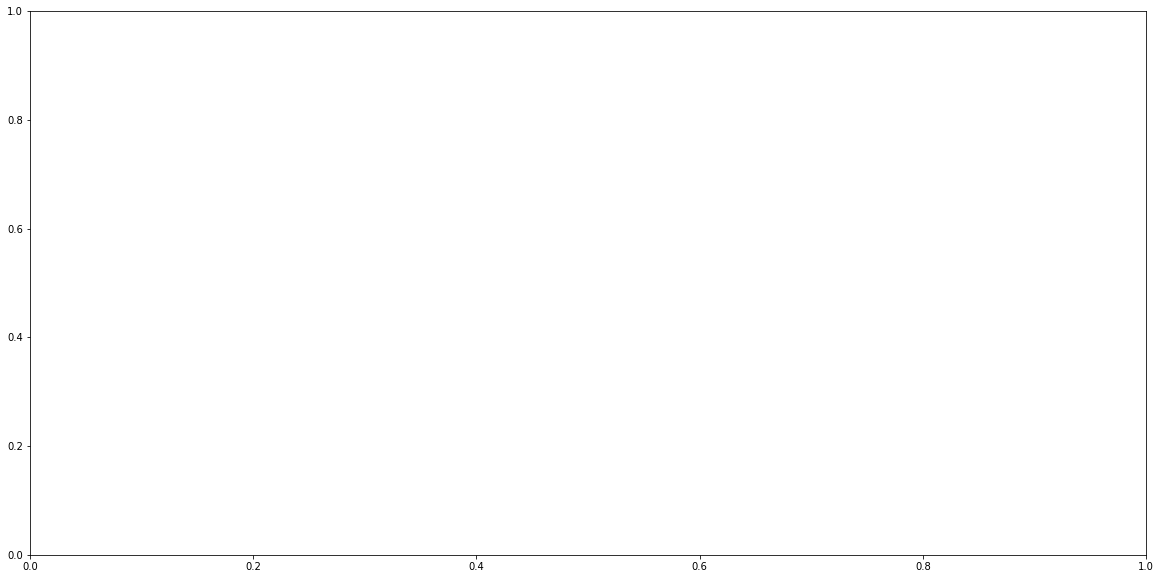

In [9]:
#プロット
feature = 'CM'
mode = 'Charge'
cycles = df_unit_1['Cycle'].unique()
cutoff_time = 11000

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)

for cycle in cycles:
  #df_plot = df[df['Time'] < cutoff_time]
  df_plot = df_unit_1
  plot_x = df_plot[ (df_plot['unit_name'] == unit) & (df_plot['Cycle'] == cycle) & (df_plot['mode'] == mode)]['Time']
  plot_y = df_plot[ (df_plot['unit_name'] == unit) & (df_plot['Cycle'] == cycle) & (df_plot['mode'] == mode)][feature]
  ax.plot(plot_x, plot_y, label= f'{unit}__{feature}__{cycle}Cycle')
  #ax.set_xticks(np.arange(0, cutoff_time, 1000))
  #ax.set_ylim(3, 5)

#plt.legend()
plt.show()

In [10]:
#外れ値探索
feature = 'CC'
mode = 'Charge'

#最大
#outlier_idx = df_unit_1[feature].argmax()
#最小
outlier_idx = df_unit_1[feature].argmin()

df_unit_1.iloc[outlier_idx,]

Time                2.531
VM                 3.8194
VC                  1.668
CM                -4.4797
CC                 -4.468
Temp               23.892
unit_name    Train_Unit_1
mode               Charge
Cycle                  32
VL                    NaN
CL                    NaN
Name: 34407, dtype: object

元データから、32Cycleのデータは削除しておく。

In [11]:
#32サイクル目を除去。(=Cycle=32でないもののみ、抜き出し。)
df_unit_1 = df_unit_1[df_unit_1['Cycle'] !=32]

In [12]:
df_unit_1.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL
0,0.000,3.3251,0.003,0.000302,-0.002,29.342,Train_Unit_1,Charge,1,NaN,NaN
1,2.516,3.0020,1.414,-3.362000,-3.370,29.336,Train_Unit_1,Charge,1,NaN,NaN
2,5.500,3.4346,4.142,1.508700,1.498,29.335,Train_Unit_1,Charge,1,NaN,NaN
3,8.391,3.4549,4.180,1.510000,1.498,29.342,Train_Unit_1,Charge,1,NaN,NaN
4,11.266,3.4688,4.196,1.508700,1.498,29.331,Train_Unit_1,Charge,1,NaN,NaN


# 辞書学習による特徴量の抽出

50秒間に抜き出す(統計量)データセットを作成  
⇒1サイクルあたり、11000/50 = 220コ×124Cycleのかたまりができるイメージ。  

※インターバルが小さすぎるとピボットテーブル化した時にNaNが出る。  
削除で対処するが、削られる欠測の数で調整が必要。

In [13]:
df_unit_1_C = df_unit_1[df_unit_1['mode'] == 'Charge']
df_unit_1_D = df_unit_1[df_unit_1['mode'] == 'Discharge']

In [14]:
#関数化：グループIDを付与する。
def add_group(max_value, df, interval):
  group_list = []
  for i in np.arange(1, max_value/interval):
      lower = interval*i-interval
      upper = interval*i
      tmp_df = df[ (lower < df['Time']) & (upper > df['Time'])]
      tmp_df['group_id'] = f'{lower} -- {upper}'
      group_list.append(tmp_df)
  df_add_group = pd.concat(group_list)
  return df_add_group

In [15]:
#インターバルは50sec。
grouped_unit_1_C = add_group(11000, df_unit_1_C, interval=50)
grouped_unit_1_C = grouped_unit_1_C.reset_index(drop=True)
grouped_unit_1_C.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL,group_id
0,2.516,3.0020,1.414,-3.3620,-3.370,29.336,Train_Unit_1,Charge,1,NaN,NaN,0.0 -- 50.0
1,5.500,3.4346,4.142,1.5087,1.498,29.335,Train_Unit_1,Charge,1,NaN,NaN,0.0 -- 50.0
2,8.391,3.4549,4.180,1.5100,1.498,29.342,Train_Unit_1,Charge,1,NaN,NaN,0.0 -- 50.0
3,11.266,3.4688,4.196,1.5087,1.498,29.331,Train_Unit_1,Charge,1,NaN,NaN,0.0 -- 50.0
4,14.141,3.4810,4.207,1.5116,1.500,29.323,Train_Unit_1,Charge,1,NaN,NaN,0.0 -- 50.0


In [16]:
#サイクル、グループID毎にグループ化し、平均値をとる。
grouped_unit_1_C_mean = grouped_unit_1_C.groupby(['Cycle', 'group_id']).mean().sort_values(['Cycle','Time'])

In [17]:
#欠測値の確認。この状態だと基本なし。
grouped_unit_1_C_mean.isnull().sum()

Time        0
VM          0
VC          0
CM          0
CC          0
Temp        0
VL      25817
CL      25817
dtype: int64

In [18]:
#ピボットテーブルを作成(VM)
pt_VM = pd.pivot_table(grouped_unit_1_C_mean, index='group_id', columns='Cycle', values='VM')
#欠測値は削除。
pt_VM = pt_VM.dropna()
pt_VM.isnull().sum()
pt_VM.shape

(192, 123)

In [19]:
from sklearn.decomposition import DictionaryLearning

In [20]:
X_VM = np.asarray(pt_VM.values)
X_train = X_VM

In [21]:
n_components = 10
dict_learner = DictionaryLearning(
    n_components=n_components,
    fit_algorithm='cd',
    transform_algorithm = 'lasso_lars',
    random_state = 42,
    positive_code = True,
    positive_dict = True,
    alpha = 1
)

In [22]:
X_train_transformed = dict_learner.fit_transform(X_train)

In [23]:
time_range = np.arange(dict_learner.components_.shape[1])
time_range

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122])

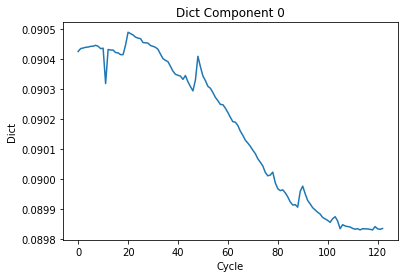

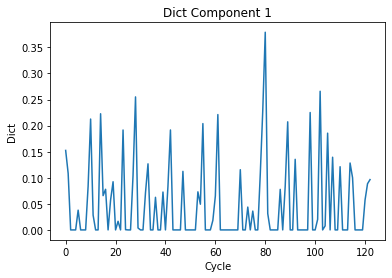

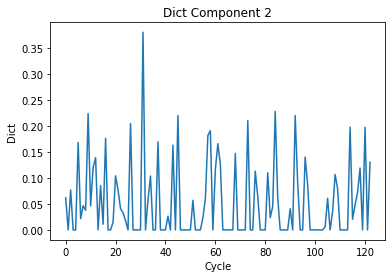

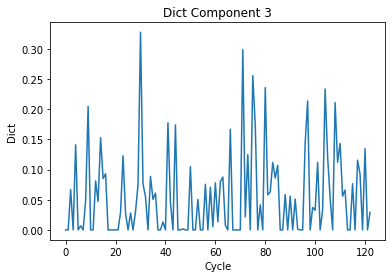

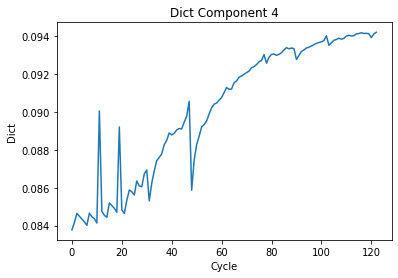

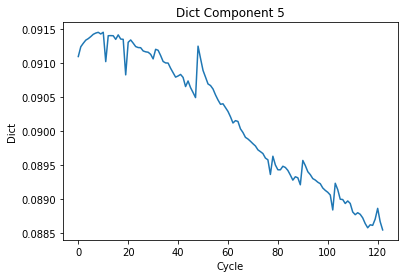

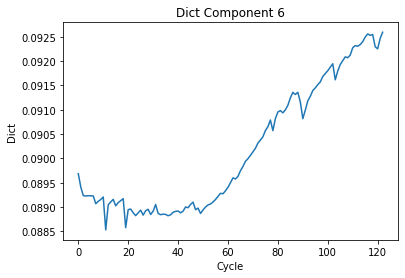

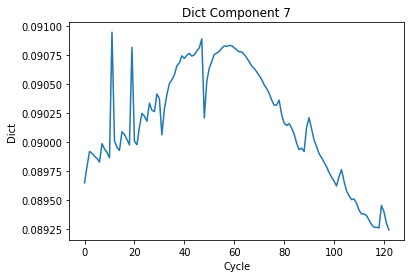

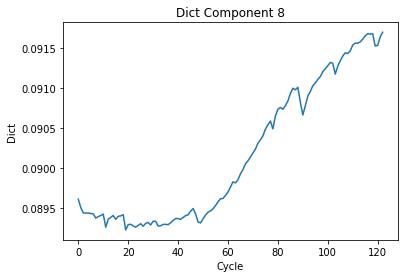

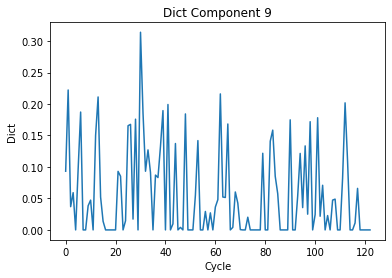

In [24]:
for i in range(n_components):
  fig, ax = plt.subplots()
  ax.plot(time_range, dict_learner.components_[i])
  ax.set_title(f'Dict Component {i}')
  ax.set_xlabel('Cycle')
  ax.set_ylabel('Dict')
  #plt.legend()
  plt.show()
  

In [25]:
#データフレームに残す。
dict_a = dict_learner.components_.T
dict_a

array([[0.09042595, 0.15240638, 0.06167356, ..., 0.08965007, 0.08961563,
        0.09322786],
       [0.09043553, 0.10838037, 0.        , ..., 0.08979321, 0.08950999,
        0.2222426 ],
       [0.09043746, 0.        , 0.07661921, ..., 0.08992023, 0.08944525,
        0.0369318 ],
       ...,
       [0.08983539, 0.05726045, 0.19708235, ..., 0.0894021 , 0.09153047,
        0.        ],
       [0.08983358, 0.08861996, 0.        , ..., 0.08930387, 0.09163478,
        0.        ],
       [0.08983632, 0.09646561, 0.12986969, ..., 0.08924529, 0.09169403,
        0.        ]])

In [42]:
cols = []
for i in np.arange(0, 10):
  col = f'Component_{i}'
  cols.append(col)

In [43]:
cols

['Component_0',
 'Component_1',
 'Component_2',
 'Component_3',
 'Component_4',
 'Component_5',
 'Component_6',
 'Component_7',
 'Component_8',
 'Component_9']

In [44]:
df_dict_VM = pd.DataFrame(dict_a, columns=cols)

In [45]:
df_dict_VM

,Component_0,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9
0,0.090426,0.152406,0.061674,0.000000,0.083775,0.091097,0.089686,0.089650,0.089616,0.093228
1,0.090436,0.108380,0.000000,0.000000,0.084171,0.091240,0.089411,0.089793,0.089510,0.222243
2,0.090437,0.000000,0.076619,0.066920,0.084650,0.091291,0.089236,0.089920,0.089445,0.036932
3,0.090440,0.000000,0.000000,0.000000,0.084496,0.091337,0.089227,0.089904,0.089442,0.059181
4,0.090441,0.000000,0.000000,0.141081,0.084346,0.091360,0.089235,0.089880,0.089443,0.000000
...,...,...,...,...,...,...,...,...,...,...
118,0.089832,0.000000,0.118829,0.092309,0.094150,0.088619,0.092547,0.089262,0.091677,0.000000
119,0.089843,0.000000,0.000000,0.000000,0.094128,0.088710,0.092296,0.089456,0.091523,0.000000
120,0.089835,0.057260,0.197082,0.134645,0.093922,0.088869,0.092252,0.089402,0.091530,0.000000
121,0.089834,0.088620,0.000000,0.000000,0.094108,0.088674,0.092466,0.089304,0.091635,0.000000


連続処理

In [28]:
grouped_unit_1_C_mean.columns

Index(['Time', 'VM', 'VC', 'CM', 'CC', 'Temp', 'VL', 'CL'], dtype='object')

In [29]:
#対象カラムリスト
col_charge = grouped_unit_1_C_mean.columns[2:6]
col_charge

Index(['VC', 'CM', 'CC', 'Temp'], dtype='object')

In [60]:
#base_df = grouped_unit_1_C_mean
#col = 'VC'
#mode = 'C'

def components_to_DF(base_df, col, mode):
  #ピボットテーブルを作成
  pt = pd.pivot_table(base_df, index='group_id', columns='Cycle', values=col)
  #欠測値は削除。
  pt = pt.dropna()

  X = np.asarray(pt.values)
  X_train = X

  n_components = 10
  dict_learner = DictionaryLearning(
        n_components=n_components,
        fit_algorithm='cd',
        transform_algorithm = 'lasso_lars',
        random_state = 42,
        positive_code = True,
        positive_dict = True,
        alpha = 1
    )

  X_train_transformed = dict_learner.fit_transform(X_train)

  cols = []
  for i in np.arange(0, 10):
    c = f'Component_{i}_{col}_{mode}'
    cols.append(c)
  
  df_dict = pd.DataFrame(dict_learner.components_.T, columns=cols)

  return df_dict

In [76]:
df_dict_VM_c = components_to_DF(grouped_unit_1_C_mean, 'VM', 'C')
df_dict_VC_c = components_to_DF(grouped_unit_1_C_mean, 'VC', 'C')
df_dict_CM_c = components_to_DF(grouped_unit_1_C_mean, 'CM', 'C')
df_dict_CC_c = components_to_DF(grouped_unit_1_C_mean, 'CC', 'C')
df_dict_Temp_c = components_to_DF(grouped_unit_1_C_mean, 'Temp', 'C')

VLのみ処理

In [77]:
#インターバルは50sec。
grouped_unit_1_D = add_group(11000, df_unit_1_D, interval=50)
grouped_unit_1_D = grouped_unit_1_D.reset_index(drop=True)
grouped_unit_1_D.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL,group_id
0,16.781,4.1907,NaN,-0.001478,NaN,24.326,Train_Unit_1,Discharge,1,4.206,-0.0006,0.0 -- 50.0
1,35.703,3.9749,NaN,-2.012500,NaN,24.389,Train_Unit_1,Discharge,1,3.062,-1.9982,0.0 -- 50.0
2,16.672,4.1889,NaN,-0.000879,NaN,24.686,Train_Unit_1,Discharge,2,4.204,-0.0006,0.0 -- 50.0
3,35.703,3.9792,NaN,-2.014700,NaN,24.738,Train_Unit_1,Discharge,2,3.056,-1.9984,0.0 -- 50.0
4,16.797,4.1872,NaN,-0.001792,NaN,24.741,Train_Unit_1,Discharge,3,4.203,-0.0006,0.0 -- 50.0


In [78]:
#サイクル、グループID毎にグループ化し、平均値をとる。
grouped_unit_1_D_mean = grouped_unit_1_D.groupby(['Cycle', 'group_id']).mean().sort_values(['Cycle','Time'])

In [79]:
#欠測値の確認。この状態だと基本なし。
grouped_unit_1_D_mean.isnull().sum()

Time       0
VM         0
VC      7387
CM         0
CC      7387
Temp       0
VL         0
CL         0
dtype: int64

In [80]:
df_dict_VM_d = components_to_DF(grouped_unit_1_D_mean,'VM', 'D')
df_dict_CM_d = components_to_DF(grouped_unit_1_D_mean,'CM', 'D')
df_dict_Temp_d = components_to_DF(grouped_unit_1_D_mean,'Temp', 'D')
df_dict_VL_d = components_to_DF(grouped_unit_1_D_mean,'VL', 'D')
#df_dict_CL_d = components_to_DF(grouped_unit_1_D_mean,'CC')：CLは無し。

In [81]:
df_dict_VL_d

,Component_0_VL_D,Component_1_VL_D,Component_2_VL_D,Component_3_VL_D,Component_4_VL_D,Component_5_VL_D,Component_6_VL_D,Component_7_VL_D,Component_8_VL_D,Component_9_VL_D
0,0.018419,0.096646,0.091854,0.093100,0.060703,0.000000,0.086624,0.000000,0.000000,0.059665
1,0.043750,0.096522,0.091535,0.000000,0.094849,0.023968,0.082550,0.000000,0.008952,0.030656
2,0.068880,0.096382,0.091460,0.000000,0.078682,0.111580,0.016902,0.000000,0.217162,0.077345
3,0.000000,0.096319,0.091431,0.081007,0.060267,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.096326,0.091475,0.124272,0.019724,0.000000,0.175582,0.000000,0.036787,0.211476
...,...,...,...,...,...,...,...,...,...,...
118,0.000000,0.080216,0.089985,0.000000,0.155814,0.268272,0.000000,0.148056,0.084741,0.156341
119,0.000000,0.080692,0.089927,0.073207,0.236597,0.000000,0.000000,0.009509,0.146052,0.000000
120,0.000000,0.078291,0.090018,0.000000,0.000000,0.000000,0.086956,0.099769,0.000000,0.000000
121,0.000000,0.076933,0.089906,0.050844,0.005717,0.219494,0.000000,0.097750,0.000000,0.105536


特徴量の選択：Cycle数と相関が高いものを抽出

NameError: ignored

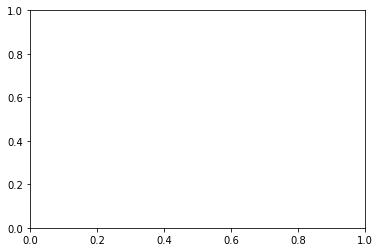

In [69]:
#comp = df_dict_VM_c 0,4,5,6,7,8
#comp = df_dict_VC_c 2,4
#comp = df_dict_CM_c 1,2,6
#comp = df_dict_CC_c 1,2,6
#comp = df_dict_Temp_c 1,4
#comp = df_dict_VM_d 1
#comp = df_dict_CM_d ×
#comp = df_dict_Temp_d 1,3
#comp = df_dict_VL_d 1

for i in range(0 , 10):
  fig, ax = plt.subplots()
  ax.plot(comp.index, comp[i])
  ax.set_title(f'Component：{i}')
  ax.set_xlabel('Cycle')
  ax.set_ylabel('Dict')
  plt.show()

In [82]:
df_dict_VM_c.head()

,Component_0_VM_C,Component_1_VM_C,Component_2_VM_C,Component_3_VM_C,Component_4_VM_C,Component_5_VM_C,Component_6_VM_C,Component_7_VM_C,Component_8_VM_C,Component_9_VM_C
0,0.090426,0.152406,0.061674,0.000000,0.083775,0.091097,0.089686,0.089650,0.089616,0.093228
1,0.090436,0.108380,0.000000,0.000000,0.084171,0.091240,0.089411,0.089793,0.089510,0.222243
2,0.090437,0.000000,0.076619,0.066920,0.084650,0.091291,0.089236,0.089920,0.089445,0.036932
3,0.090440,0.000000,0.000000,0.000000,0.084496,0.091337,0.089227,0.089904,0.089442,0.059181
4,0.090441,0.000000,0.000000,0.141081,0.084346,0.091360,0.089235,0.089880,0.089443,0.000000


In [84]:
#特徴量の選択
df_1 = df_dict_VM_c.iloc[:, [0,4,5,6,7,8]]
df_2 = df_dict_VC_c.iloc[:, [2,4]]
df_3 = df_dict_CM_c.iloc[:, [1,2,6]]
df_4 = df_dict_CC_c.iloc[:, [1,2,6]]
df_5 = df_dict_Temp_c.iloc[:, [1,4]]
df_6 = df_dict_VM_d.iloc[:, [1]]
df_7 = df_dict_Temp_d.iloc[:, [1,3]]
df_8 = df_dict_VL_d.iloc[:, [1]]

In [89]:
str_1 = 'A'
str_2 = 'B'
str_3 = 'C'

for i in range(1, 4):
  #print(str_i)
  exec_command = 'print(str_' + str(i) + ')'
  exec(exec_command)

A
B
C


In [92]:
#変数名の連番取得
df_number = []
for i in range(1, 9):
  exec_command = 'df_number.append(str(df_' + str(i) + '))'
  exec(exec_command)
df_number

['     Component_0_VM_C  Component_4_VM_C  ...  Component_7_VM_C  Component_8_VM_C\n0            0.090426          0.083775  ...          0.089650          0.089616\n1            0.090436          0.084171  ...          0.089793          0.089510\n2            0.090437          0.084650  ...          0.089920          0.089445\n3            0.090440          0.084496  ...          0.089904          0.089442\n4            0.090441          0.084346  ...          0.089880          0.089443\n..                ...               ...  ...               ...               ...\n118          0.089832          0.094150  ...          0.089262          0.091677\n119          0.089843          0.094128  ...          0.089456          0.091523\n120          0.089835          0.093922  ...          0.089402          0.091530\n121          0.089834          0.094108  ...          0.089304          0.091635\n122          0.089836          0.094206  ...          0.089245          0.091694\n\n[123 rows x 

In [93]:
df_dict_merge = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8], axis=1)

In [94]:
df_dict_merge

,Component_0_VM_C,Component_4_VM_C,Component_5_VM_C,Component_6_VM_C,Component_7_VM_C,Component_8_VM_C,Component_2_VC_C,Component_4_VC_C,Component_1_CM_C,Component_2_CM_C,Component_6_CM_C,Component_1_CC_C,Component_2_CC_C,Component_6_CC_C,Component_1_Temp_C,Component_4_Temp_C,Component_1_VM_D,Component_1_Temp_D,Component_3_Temp_D,Component_1_VL_D
0,0.090426,0.083775,0.091097,0.089686,0.089650,0.089616,0.097345,0.089231,0.126304,0.099976,0.090270,0.126332,0.100030,0.090278,0.089559,0.071698,0.091161,0.087262,0.070494,0.096646
1,0.090436,0.084171,0.091240,0.089411,0.089793,0.089510,0.097390,0.089253,0.125938,0.100044,0.090267,0.125942,0.100049,0.090268,0.090023,0.071846,0.091287,0.087560,0.073134,0.096522
2,0.090437,0.084650,0.091291,0.089236,0.089920,0.089445,0.097254,0.089285,0.124594,0.100212,0.090263,0.124639,0.100198,0.090251,0.089801,0.071513,0.091324,0.087367,0.073891,0.096382
3,0.090440,0.084496,0.091337,0.089227,0.089904,0.089442,0.097322,0.089282,0.124770,0.100104,0.090255,0.124782,0.100153,0.090245,0.089428,0.071348,0.091356,0.087021,0.073595,0.096319
4,0.090441,0.084346,0.091360,0.089235,0.089880,0.089443,0.097350,0.089277,0.124731,0.100141,0.090240,0.124811,0.100178,0.090243,0.089107,0.071431,0.091369,0.086682,0.074142,0.096326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.089832,0.094150,0.088619,0.092547,0.089262,0.091677,0.081266,0.090978,0.047251,0.051061,0.088933,0.047210,0.051054,0.088935,0.097516,0.111567,0.088000,0.097287,0.118168,0.080216
119,0.089843,0.094128,0.088710,0.092296,0.089456,0.091523,0.081849,0.090975,0.049174,0.056774,0.089544,0.049151,0.056790,0.089541,0.096082,0.113962,0.088191,0.097649,0.115752,0.080692
120,0.089835,0.093922,0.088869,0.092252,0.089402,0.091530,0.081871,0.090938,0.049255,0.056266,0.089590,0.049194,0.056264,0.089588,0.096744,0.112610,0.087801,0.097501,0.120930,0.078291
121,0.089834,0.094108,0.088674,0.092466,0.089304,0.091635,0.081435,0.090972,0.047938,0.052529,0.089164,0.047871,0.052532,0.089153,0.095606,0.112131,0.087581,0.097209,0.122097,0.076933


In [95]:
feature_dict = df_dict_merge
feature_dict['RLU'] = feature_dict.index + 1
feature_dict['RLU'] = 123 - feature_dict['RLU']
feature_dict

,Component_0_VM_C,Component_4_VM_C,Component_5_VM_C,Component_6_VM_C,Component_7_VM_C,Component_8_VM_C,Component_2_VC_C,Component_4_VC_C,Component_1_CM_C,Component_2_CM_C,Component_6_CM_C,Component_1_CC_C,Component_2_CC_C,Component_6_CC_C,Component_1_Temp_C,Component_4_Temp_C,Component_1_VM_D,Component_1_Temp_D,Component_3_Temp_D,Component_1_VL_D,RLU
0,0.090426,0.083775,0.091097,0.089686,0.089650,0.089616,0.097345,0.089231,0.126304,0.099976,0.090270,0.126332,0.100030,0.090278,0.089559,0.071698,0.091161,0.087262,0.070494,0.096646,122
1,0.090436,0.084171,0.091240,0.089411,0.089793,0.089510,0.097390,0.089253,0.125938,0.100044,0.090267,0.125942,0.100049,0.090268,0.090023,0.071846,0.091287,0.087560,0.073134,0.096522,121
2,0.090437,0.084650,0.091291,0.089236,0.089920,0.089445,0.097254,0.089285,0.124594,0.100212,0.090263,0.124639,0.100198,0.090251,0.089801,0.071513,0.091324,0.087367,0.073891,0.096382,120
3,0.090440,0.084496,0.091337,0.089227,0.089904,0.089442,0.097322,0.089282,0.124770,0.100104,0.090255,0.124782,0.100153,0.090245,0.089428,0.071348,0.091356,0.087021,0.073595,0.096319,119
4,0.090441,0.084346,0.091360,0.089235,0.089880,0.089443,0.097350,0.089277,0.124731,0.100141,0.090240,0.124811,0.100178,0.090243,0.089107,0.071431,0.091369,0.086682,0.074142,0.096326,118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.089832,0.094150,0.088619,0.092547,0.089262,0.091677,0.081266,0.090978,0.047251,0.051061,0.088933,0.047210,0.051054,0.088935,0.097516,0.111567,0.088000,0.097287,0.118168,0.080216,4
119,0.089843,0.094128,0.088710,0.092296,0.089456,0.091523,0.081849,0.090975,0.049174,0.056774,0.089544,0.049151,0.056790,0.089541,0.096082,0.113962,0.088191,0.097649,0.115752,0.080692,3
120,0.089835,0.093922,0.088869,0.092252,0.089402,0.091530,0.081871,0.090938,0.049255,0.056266,0.089590,0.049194,0.056264,0.089588,0.096744,0.112610,0.087801,0.097501,0.120930,0.078291,2
121,0.089834,0.094108,0.088674,0.092466,0.089304,0.091635,0.081435,0.090972,0.047938,0.052529,0.089164,0.047871,0.052532,0.089153,0.095606,0.112131,0.087581,0.097209,0.122097,0.076933,1


学習

In [96]:
train_X = feature_dict.iloc[:, :-1]
train_y = feature_dict.iloc[:,-1]

In [97]:
train_X
train_y

0      122
1      121
2      120
3      119
4      118
      ... 
118      4
119      3
120      2
121      1
122      0
Name: RLU, Length: 123, dtype: int64

In [98]:
from xgboost import XGBRegressor

In [99]:
#モデルの作成
model = XGBRegressor(n_estimators=20, random_state=71)
model.fit(train_X,train_y)

[14:34:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=71,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

テストデータの読み込み～加工

In [105]:
#データの読み込み
df_test_0 = pd.read_csv(
    os.path.join(DIR, 'data', 'Test_Unit_20210903', 'dataset_test_all.csv'),
    encoding='utf-8')
#不必要なIndex列と空白列を削除。
df_test_0 = df_test_0.drop(df_test_0.columns[[0, 7]], axis=1)
#データ処理用にDFをコピー
df_base_test = df_test_0.copy()

In [106]:
df_test_0.head()

,Time (s),Voltage Measured (V),Voltage Charge (V),Current Measured (Amps),Current Charge (Amps),Temperature (degree C),unit,charge_mode,Cycle_num,Voltage Load (V),Current Load (Amps)
0,0.000,3.4268,-0.007,0.000887,0.000,33.569,Test_Unit_1,Charge,61,NaN,NaN
1,2.484,3.1242,1.439,-3.518300,-3.536,33.511,Test_Unit_1,Charge,61,NaN,NaN
2,7.297,3.5065,4.219,1.516100,1.507,33.502,Test_Unit_1,Charge,61,NaN,NaN
3,11.891,3.5454,4.273,1.517200,1.507,33.491,Test_Unit_1,Charge,61,NaN,NaN
4,16.484,3.5689,4.295,1.517200,1.507,33.453,Test_Unit_1,Charge,61,NaN,NaN


In [107]:
df_base_test = df_base_test.rename(columns=col_list)
#ユニットとサイクルでソート。
df_base_test = df_base_test.sort_values(['unit_name', 'Cycle']).reset_index(drop=True)

In [108]:
df_base_test.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL
0,0.000,3.3426,-0.007,-0.000337,0.000,24.257,Test_Unit_1,Charge,1,NaN,NaN
1,2.485,2.9686,1.396,-3.326200,-3.342,24.255,Test_Unit_1,Charge,1,NaN,NaN
2,5.219,3.4795,4.187,1.515600,1.507,24.287,Test_Unit_1,Charge,1,NaN,NaN
3,7.766,3.4979,4.219,1.513700,1.507,24.300,Test_Unit_1,Charge,1,NaN,NaN
4,10.313,3.5105,4.235,1.516100,1.507,24.299,Test_Unit_1,Charge,1,NaN,NaN


In [117]:
df_test_unit_1 = df_base_test[df_base_test['unit_name'] == 'Test_Unit_1'].reset_index(drop=True)
df_test_unit_2 = df_base_test[df_base_test['unit_name'] == 'Test_Unit_2'].reset_index(drop=True)
df_test_unit_3 = df_base_test[df_base_test['unit_name'] == 'Test_Unit_3'].reset_index(drop=True)

In [121]:
df_test_unit_1.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL
0,0.000,3.3426,-0.007,-0.000337,0.000,24.257,Test_Unit_1,Charge,1,NaN,NaN
1,2.485,2.9686,1.396,-3.326200,-3.342,24.255,Test_Unit_1,Charge,1,NaN,NaN
2,5.219,3.4795,4.187,1.515600,1.507,24.287,Test_Unit_1,Charge,1,NaN,NaN
3,7.766,3.4979,4.219,1.513700,1.507,24.300,Test_Unit_1,Charge,1,NaN,NaN
4,10.313,3.5105,4.235,1.516100,1.507,24.299,Test_Unit_1,Charge,1,NaN,NaN


In [122]:
df_test_unit_1_C = df_test_unit_1[df_test_unit_1['mode'] == 'Charge']
df_test_unit_1_D = df_test_unit_1[df_test_unit_1['mode'] == 'Discharge']

In [123]:
#インターバルは50sec。
grouped_test_unit_1_C = add_group(11000, df_test_unit_1_C, interval=50)
grouped_test_unit_1_C = grouped_test_unit_1_C.reset_index(drop=True)
grouped_test_unit_1_C.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL,group_id
0,2.485,2.9686,1.396,-3.3262,-3.342,24.255,Test_Unit_1,Charge,1,NaN,NaN,0.0 -- 50.0
1,5.219,3.4795,4.187,1.5156,1.507,24.287,Test_Unit_1,Charge,1,NaN,NaN,0.0 -- 50.0
2,7.766,3.4979,4.219,1.5137,1.507,24.300,Test_Unit_1,Charge,1,NaN,NaN,0.0 -- 50.0
3,10.313,3.5105,4.235,1.5161,1.507,24.299,Test_Unit_1,Charge,1,NaN,NaN,0.0 -- 50.0
4,12.875,3.5218,4.246,1.5162,1.507,24.299,Test_Unit_1,Charge,1,NaN,NaN,0.0 -- 50.0


In [124]:
#インターバルは50sec。
grouped_test_unit_1_D = add_group(11000, df_test_unit_1_D, interval=50)
grouped_test_unit_1_D = grouped_test_unit_1_D.reset_index(drop=True)
grouped_test_unit_1_D.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL,group_id
0,9.422,4.1882,NaN,0.001459,NaN,23.829,Test_Unit_1,Discharge,1,4.203,0.0006,0.0 -- 50.0
1,19.578,3.9774,NaN,-2.005700,NaN,23.845,Test_Unit_1,Discharge,1,3.029,1.9988,0.0 -- 50.0
2,29.016,3.9620,NaN,-2.012200,NaN,23.926,Test_Unit_1,Discharge,1,3.026,1.9988,0.0 -- 50.0
3,38.485,3.9498,NaN,-2.012000,NaN,24.011,Test_Unit_1,Discharge,1,3.015,1.9988,0.0 -- 50.0
4,47.906,3.9396,NaN,-2.007300,NaN,24.103,Test_Unit_1,Discharge,1,3.005,1.9988,0.0 -- 50.0


In [125]:
#サイクル、グループID毎にグループ化し、平均値をとる。
grouped_test_unit_1_C_mean = grouped_test_unit_1_C.groupby(['Cycle', 'group_id']).mean().sort_values(['Cycle','Time'])
grouped_test_unit_1_D_mean = grouped_test_unit_1_D.groupby(['Cycle', 'group_id']).mean().sort_values(['Cycle','Time'])

In [126]:
df_test_dict_VM_c = components_to_DF(grouped_test_unit_1_C_mean, 'VM', 'C')
df_test_dict_VC_c = components_to_DF(grouped_test_unit_1_C_mean, 'VC', 'C')
df_test_dict_CM_c = components_to_DF(grouped_test_unit_1_C_mean, 'CM', 'C')
df_test_dict_CC_c = components_to_DF(grouped_test_unit_1_C_mean, 'CC', 'C')
df_test_dict_Temp_c = components_to_DF(grouped_test_unit_1_C_mean, 'Temp', 'C')
df_test_dict_VM_d = components_to_DF(grouped_test_unit_1_D_mean,'VM', 'D')
df_test_dict_CM_d = components_to_DF(grouped_test_unit_1_D_mean,'CM', 'D')
df_test_dict_Temp_d = components_to_DF(grouped_test_unit_1_D_mean,'Temp', 'D')
df_test_dict_VL_d = components_to_DF(grouped_test_unit_1_D_mean,'VL', 'D')

In [127]:
#特徴量の選択
df_test_1 = df_test_dict_VM_c.iloc[:, [0,4,5,6,7,8]]
df_test_2 = df_test_dict_VC_c.iloc[:, [2,4]]
df_test_3 = df_test_dict_CM_c.iloc[:, [1,2,6]]
df_test_4 = df_test_dict_CC_c.iloc[:, [1,2,6]]
df_test_5 = df_test_dict_Temp_c.iloc[:, [1,4]]
df_test_6 = df_test_dict_VM_d.iloc[:, [1]]
df_test_7 = df_test_dict_Temp_d.iloc[:, [1,3]]
df_test_8 = df_test_dict_VL_d.iloc[:, [1]]

In [128]:
df_test_dict_merge = pd.concat([df_test_1, df_test_2, df_test_3, df_test_4, df_test_5, df_test_6, df_test_7, df_test_8], axis=1)

In [129]:
df_test_dict_merge.head()

,Component_0_VM_C,Component_4_VM_C,Component_5_VM_C,Component_6_VM_C,Component_7_VM_C,Component_8_VM_C,Component_2_VC_C,Component_4_VC_C,Component_1_CM_C,Component_2_CM_C,Component_6_CM_C,Component_1_CC_C,Component_2_CC_C,Component_6_CC_C,Component_1_Temp_C,Component_4_Temp_C,Component_1_VM_D,Component_1_Temp_D,Component_3_Temp_D,Component_1_VL_D
0,0.119449,0.119336,0.119617,0.000000,0.116113,0.118285,0.184309,0.119971,0.316629,0.000000,0.121055,0.084065,0.000000,0.121116,0.115593,0.070178,0.053571,0.120609,0.000000,0.00000
1,0.118890,0.119167,0.119048,0.000000,0.116514,0.118533,0.000000,0.119528,0.081938,0.000000,0.121110,0.114346,0.000000,0.121109,0.117153,0.080714,0.272782,0.120947,0.000000,0.00000
2,0.118972,0.119080,0.119148,0.108597,0.116549,0.118428,0.000000,0.119529,0.010898,0.000000,0.121116,0.000000,0.316569,0.121106,0.114663,0.079157,0.149001,0.118858,0.192280,0.00000
3,0.119427,0.119006,0.119766,0.282063,0.116425,0.118064,0.000000,0.119908,0.000000,0.000000,0.121100,0.000000,0.000000,0.121116,0.112797,0.068203,0.000000,0.117149,0.000000,0.00000
4,0.118122,0.119135,0.117826,0.000000,0.117498,0.119493,0.000000,0.118947,0.135617,0.116713,0.121107,0.083921,0.000000,0.121116,0.125664,0.146507,0.093677,0.121128,0.057128,0.32149


In [130]:
test_X = df_test_dict_merge

In [131]:
#テストデータの予測値を出力
pred = model.predict(test_X)
pred

array([67.69974 , 66.32223 , 64.31731 , 66.94498 , 73.6668  , 55.553787,
       72.871895, 56.348694, 88.200676, 52.987514, 72.871895, 72.871895,
       55.553787, 88.99558 , 55.553787, 55.07694 , 72.871895, 51.71576 ,
       66.94498 , 72.871895, 52.510666, 52.987514, 53.78242 , 67.69974 ,
       70.30562 , 52.510666, 55.553787, 54.282032, 83.476944, 55.553787,
       53.78242 , 52.987514, 72.871895, 83.22692 , 54.282032, 53.78242 ,
       52.987514, 51.71576 , 67.69974 , 56.348694, 55.553787, 55.553787,
       71.100525, 67.69974 , 52.987514, 86.429306, 52.987514, 55.553787,
       52.987514, 52.987514, 65.92836 , 52.987514, 55.553787, 52.987514,
       55.553787, 66.94498 , 88.99558 , 52.987514, 56.348694, 71.100525,
       73.6668  , 65.13346 , 56.348694, 55.553787, 72.871895, 54.282032,
       66.94498 , 55.553787, 55.07694 , 72.871895], dtype=float32)

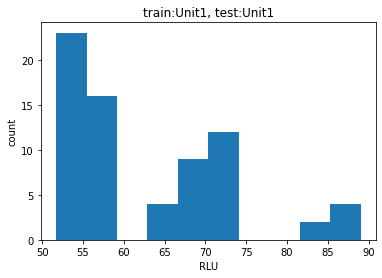

In [132]:
fig, ax = plt.subplots()

ax.hist(pred, bins=10)

ax.set_title('train:Unit1, test:Unit1')
ax.set_xlabel('RLU')
ax.set_ylabel('count')

plt.show()